In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             roc_curve, auc)

In [3]:
# Importing dataset
df = pd.read_csv('15s_Data.csv')
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1,VPN
0,14609555,14609555,14257477,41,53236,2822141,2823216,486985.166667,648067.136364,3.696211,...,6592862,6788103.0,6983344,276112.470129,1056123,1702460.0,2348797,914058.551263,VPN-FT,True
1,14997699,14976002,14976270,34,10,280324,318681,55672.869888,34036.977273,47.407272,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,STREAMING,False
2,14440454,14401292,14401395,959225,959133,960892,960909,960086.133333,960093.000000,2.215997,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
3,14441610,14402929,14403020,959367,958939,960982,961896,960195.266667,960201.333333,2.215819,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
4,14993539,14993539,14778375,152,7,272001,351381,105588.302817,16365.863787,69.830078,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-STREAMING,True


In [4]:
# Data Preprocessing

# Remove duplicate records 
df = df.drop_duplicates()
# Removing records with missing values
df = df.dropna()

# Removing the non-numeric 'class1' column.
features = df.drop(['class1', 'VPN'], axis=1)

# Convert VPN to numeric 0 and 1
target = df['VPN'].map({True: 1, False: 0})

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# Split data into training-testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target, test_size=0.3, random_state=42, stratify=target
)

In [6]:
# Hyperparameter tuning
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)


Best parameters: {'n_neighbors': 3}


Cross Validation Scores: [0.81430265 0.8201581  0.81225296 0.81857708 0.80909091]
Mean CV Accuracy: 81.48%


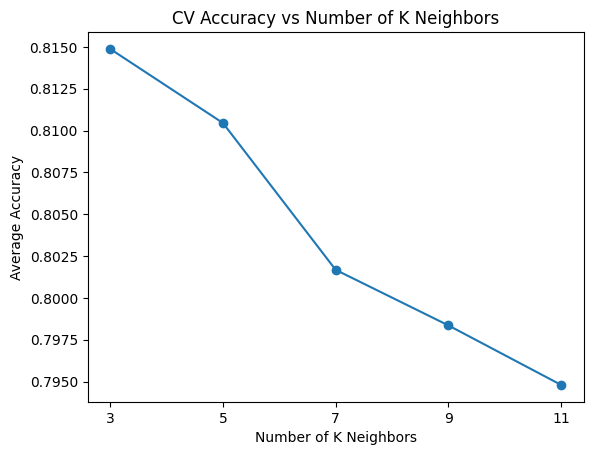

In [7]:
# Cross validation
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='accuracy')
print("Cross Validation Scores:", cv_scores)
average = cv_scores.mean() * 100
print(f"Mean CV Accuracy: {str(average)[:5]}%")

# Plot cross validation results for different k values from GridSearchCV
mean_test_scores = grid_search.cv_results_['mean_test_score']
neighbors = param_grid['n_neighbors']
plt.figure()
plt.plot(neighbors, mean_test_scores, marker='o')
plt.title('CV Accuracy vs Number of K Neighbors')
plt.xlabel('Number of K Neighbors')
plt.ylabel('Average Accuracy')
plt.xticks(neighbors)
plt.show()

Testing Accuracy: 83.05%
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2609
           1       0.84      0.83      0.83      2814

    accuracy                           0.83      5423
   macro avg       0.83      0.83      0.83      5423
weighted avg       0.83      0.83      0.83      5423



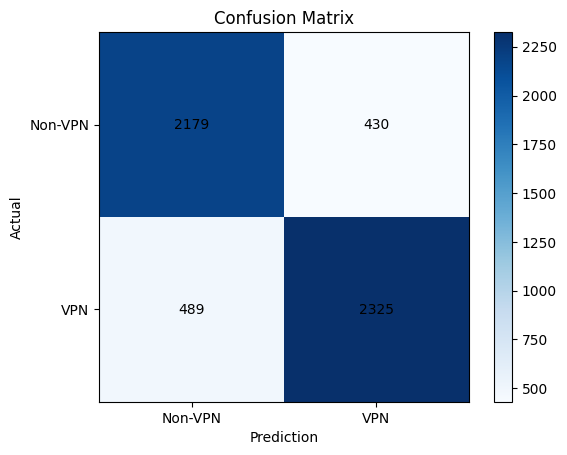

In [8]:
# Model Training and testing
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Testing Accuracy: {str(accuracy * 100)[:5]}%")
print(report)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks([0,1], ['Non-VPN', 'VPN'])
plt.yticks([0,1], ['Non-VPN', 'VPN'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
plt.show()

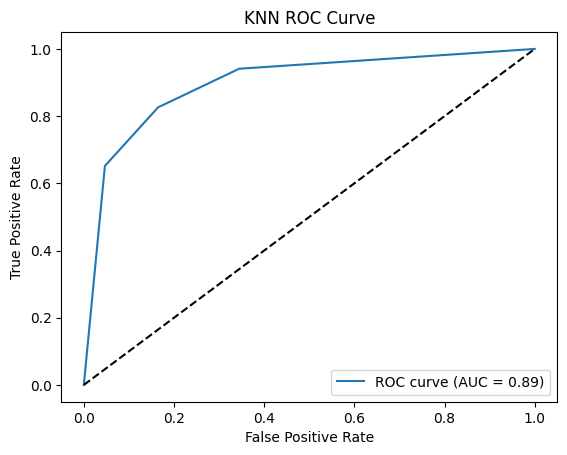

In [9]:
# Plotting ROC Curve and calculating AUC

# Getting probability estimates for the positive class.
y_prob = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {str(roc_auc)[:4]})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('KNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
